# Hypothesis Testing using Causal Bounds

In this note, we provide a tutorial on how to test the hypothesis for a given set of parameters $(f, a_{1:t}, B_{0:t})$ using our package.   

In [26]:
import sys
import numpy as np
import pandas as pd
sys.path.append("../")

## Observational and Twin data
The observational and twin data must be input as pandas dataframes, with columns named `x_t` and `actions` for $x_{0:t}$ and $a'_{1:t}$, where $x_s \in \mathcal{X}_s$ and $a'_s\in \mathcal{A}_s$, $1\leq s\leq t$.  
In this example, we use $t=3$ and generate synthetic observational dataset with $X_{s}(a_{1:s}) \sim \mathcal{N}_3(\textbf{0}, I_3)$ and $A_{s} \sim Bern(0.3)$.  
Similarly, in the twin dataset, $\widehat{X_{s}}(a_{1:s}) \sim \mathcal{N}_3(\textbf{0}, I_3)$  

The values $x_{0:3}$ are represented as a $3\times 3$ numpy array in this example, with `x[t][i]` representing the i'th component of $x_t$, i.e., $(x_t)_i$.

In [27]:
obs_data = pd.DataFrame()
n = 1000
obs_data['x_t'] = [np.random.multivariate_normal(np.zeros(3), np.eye(3), 3) for i in range(n)]
obs_data['actions'] = [np.random.binomial(1, 0.3, 2) for i in range(n)]
obs_data['actions'] = obs_data['actions'].apply(tuple)

twin_data = pd.DataFrame()
ntwin = 1000
twin_data['x_t'] = [np.random.multivariate_normal(np.zeros(3), np.eye(3), 3) for i in range(ntwin)]
twin_data['actions'] = [np.random.binomial(1, 0.3, 2) for i in range(ntwin)]
twin_data['actions'] = twin_data['actions'].apply(tuple)

In [28]:
obs_data.head()

,x_t,actions
0,"[[-1.2013163413559835, -0.3352582547475905, -0...","(0, 1)"
1,"[[0.4088144475943291, 0.8498443610088673, -0.7...","(0, 1)"
2,"[[-2.255554967462267, 1.1279769074220993, -0.7...","(0, 0)"
3,"[[0.3200351278516171, 0.18608889980133275, -0....","(0, 0)"
4,"[[0.6500042440570434, 1.6062653563770095, 0.61...","(1, 0)"


## Obtaining the $p$-values.

To run the hypothesis testing procedure, we use the function `test_hypothesis` which has the following signature:  
`test_hypothesis(obs_data, twin_data, f, at, xt_in_bt, ylo, yup, hoeffdings, reverse_percentile)`  

`f` is a callable which maps $x_{0:t}$ to the outcome, i.e. $Y = f(x_{0:t})$.  
`at` is the action sequence $a_{1:t}$ for which hypothesis is to be tested.  
`xt_in_bt` is a callable which outputs the boolean: $\texttt{xt_in_bt}(x_{0:s}) = \mathbb{1}(x_{0:s} \in B_{0:s})\texttt{True} + \mathbb{1}(x_{0:s} \notin B_{0:s})\texttt{False}$, for $1\leq s \leq t$.  
`ylo`, `yup` are $y_{\text{lo}}, y_{\text{up}}$ respectively.  
`hoeffdings` (boolean): if $\texttt{True}$, use Hoeffding's inequality for hypothesis testing, otherwise use Bootstrapping.  
`reverse_percentile` (boolean): if $\texttt{True}$ and `hoeffdings = False`, use reverse percentile method for hypothesis testing, otherwise use percentile method.  

<b>Return: $p_{\text{lo}}, p_{\text{up}}, \texttt{bootstrapping distribution dataframe}$ </b> 

In [67]:
ylo = -1.5
yup = 1.5
f = lambda x: np.clip(x[2][2], ylo, yup)
at = (0, 0)
xt_in_bt = lambda x: np.sum(x > 0)


In [68]:
from causal_bounds.hypothesis_testing import test_hypothesis

### Results using Heoffding's inequality

In [69]:
plo, pup, df = test_hypothesis(obs_data, twin_data, f, at, xt_in_bt, ylo, yup, hoeffdings=True)
print(f"p_{{lo}} = {plo} | p_{{up}} = {pup}")

p_{lo} = 1 | p_{up} = 1


### Results using Reverse percentile bootstrap

In [70]:
plo, pup, bootstrap_distributions = test_hypothesis(obs_data, twin_data, f, at, xt_in_bt, ylo, yup, hoeffdings=False, reverse_percentile=True)
print(f"p_{{lo}} = {plo} | p_{{up}} = {pup}")

p_{lo} = 1 | p_{up} = 1


In [71]:
bootstrap_distributions.head()

,Qobs,Qlo,Qup,Qobs_all_data,Qtwin,Qtwin_all_data,ylo,yup,Qlo_all_data,Qup_all_data
0,0.283080,-0.193224,0.994776,0.247302,0.142155,0.069954,-1.5,1.5,-0.213627,0.977373
1,0.241203,-0.214662,0.934338,0.247302,0.123667,0.069954,-1.5,1.5,-0.213627,0.977373
2,0.238863,-0.219433,0.974567,0.247302,0.093913,0.069954,-1.5,1.5,-0.213627,0.977373
3,0.199496,-0.245339,0.981661,0.247302,0.086621,0.069954,-1.5,1.5,-0.213627,0.977373
4,0.224527,-0.267472,1.013528,0.247302,-0.021419,0.069954,-1.5,1.5,-0.213627,0.977373


### Histogram plots of Bootstrap distributions of $Q_{lo}, \widehat{Q}, Q_{up}$.

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

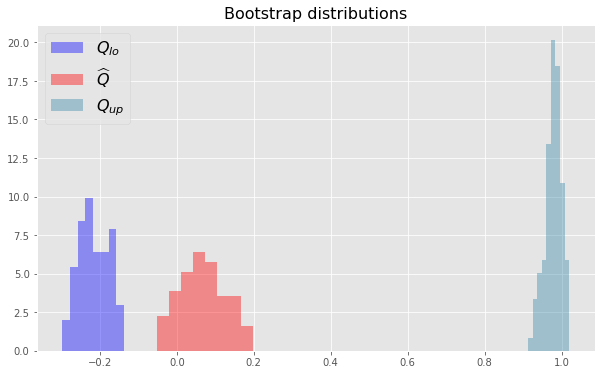

In [73]:
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 1, figsize=(10,6))
axs.hist(bootstrap_distributions['Qlo'], label='$Q_{lo}$', density=True, alpha=0.4, bins='auto', color='blue')
axs.hist(bootstrap_distributions['Qtwin'], label='$\widehat{Q}$', density=True, alpha=0.4, bins='auto', color='red')
axs.hist(bootstrap_distributions['Qup'], label='$Q_{up}$', density=True, alpha=0.4, bins='auto', color=sns.color_palette("mako", 10)[5])
plt.legend(fontsize=16)
title = plt.title("Bootstrap distributions", fontsize=16)
